In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import json
import os
import sys
import warnings
from glob import glob
from typing import Dict, List
from pathlib import Path
import shutil
from collections import defaultdict



import numpy as np
import pandas as pd
from PIL import Image
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from model import MetricModel

from dgm_utils import train_model, plot_training_curves
from dgm_utils import show_samples, visualize_images, load_dataset

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

USE_CUDA = torch.cuda.is_available()

In [3]:
class AttackedDataset(Dataset):
    def __init__(self, data_dir, reference_dir, transform=None):
        """
        Arguments:
            data_dir (string): Directory with all the images.
            reference_dir (string): Directory with reference (clear) images.
            transform (bool): True for transformation to pass to model. False to return pristine image to display
        """
        self.data_dir = data_dir
        self.reference_dir = reference_dir
        self.transform = transform
        
        self.files = sorted(glob(os.path.join(self.data_dir, "*", "*")))

    def __len__(self):
        return len(glob(os.path.join(self.data_dir, "*", "*")))

    def __getitem__(self, idx):
        img_name = self.files[idx]

        attacked_image = Image.open(img_name).convert("RGB")
        attack_name = img_name.split("/")[-2]


        reference_path = os.path.join(self.reference_dir, os.path.basename(img_name))
        reference_image = None
        if os.path.isfile(reference_path):
            reference_image = Image.open(reference_path).convert("RGB")
        else: 
            raise ValueError('wtf')
        
        if self.transform is not None:
            attacked_image, reference_image = self.transform([attacked_image, reference_image])


        return {
            "attacked_image": attacked_image,
            "reference_image": reference_image,
            "attack_name": attack_name,
        }

In [4]:
dataset = AttackedDataset(
    '00_test_file_input/attacked', 
    '00_test_file_input/reference',
    None
)

In [5]:
len(dataset)

660

In [6]:
def split_dataset(src_root, train_frac=0.6):
    src_root = Path(src_root)
    dst_root = Path('splitted')
    
    identifiers = list(filter(lambda x: x.endswith('.png'), os.listdir(src_root / 'reference')))
    identifiers = np.random.permutation(identifiers)
    
    border = int(len(identifiers) * train_frac)
    
    train, val = identifiers[:border], identifiers[border:]
    
    shutil.rmtree(dst_root, ignore_errors=True)
    
    attacks = list(os.listdir(src_root / 'attacked'))
    
    for mode, idendtifiers_subset in zip(['train', 'val'], [train, val]):
        (dst_root / mode / 'reference').mkdir(parents=True)
        for id in tqdm(idendtifiers_subset):
            shutil.copy(src_root / 'reference' / id, dst_root / mode / 'reference' / id)
            for attack in attacks:
                (dst_root / mode / 'attacked' / attack).mkdir(parents=True, exist_ok=True)
                shutil.copy(src_root /'attacked' / attack / id, dst_root / mode /'attacked' / attack / id)
                
split_dataset('/home/akkirr/AI-Masters/CV_and_VP/hw4/00_test_file_input')

100%|██████████| 24/24 [00:00<00:00, 206.57it/s]


In [34]:
from torchvision import transforms as T
import transforms as my_transforms

train_dataset = AttackedDataset(
    'splitted/train/attacked', 
    'splitted/train/reference',
    transform=T.Compose([
        my_transforms.PairedRandomCrop((200, 200)),
        my_transforms.PairedToTensor()
    ])
)

val_dataset = AttackedDataset(
    'splitted/val/attacked', 
    'splitted/val/reference',
    transform=T.Compose([
        my_transforms.PairedToTensor()
    ])
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=2,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    num_workers=2,
    shuffle=True
)

train_dataset[0]['attacked_image'].shape

torch.Size([3, 200, 200])

In [35]:
len(train_dataset), len(val_dataset)

(396, 264)

In [36]:
np.array(train_dataset[0]['attacked_image']).shape

(3, 200, 200)

In [113]:
from torch import nn

class SimpleRefiner(nn.Module):
    def __init__(self, norm_type='instance', act_type='relu'):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1)
        self.conv2 = nn.Conv2d(64, 16, 3, 1, 1)
        self.conv3 = nn.Conv2d(16, 3, 3, 1, 1)

        if norm_type == 'batch':
            # self.norm = nn.BatchNorm2d(16)
            self.norm2 = nn.BatchNorm2d(16)
        elif norm_type == 'instance':
            # self.norm = nn.InstanceNorm2d(16)
            self.norm2 = nn.InstanceNorm2d(16)
        self.leaky_relu = nn.LeakyReLU(0.2, True)

        if act_type == 'selu':
            self.act = nn.SELU(True)
        else:
            self.act = nn.ReLU(True)

        self.dropout = nn.Dropout(0.5)

        self.tanh = nn.Tanh()
    
    def forward(self, inputs):
        # Encoder
        # Convolution layers:
        # input is (nc) x 512 x 1024
        e1 = self.conv1(inputs)
        # print(f'e1 {e1.shape}')
        # state size is (ngf) x 256 x 512
        e2 = self.norm2(self.conv2(self.leaky_relu(e1)))
        # print(f'e2 {e2.shape}')
        # state size is (ngf x 2) x 128 x 256
        e3 = self.conv3(self.leaky_relu(e2))
        # print(f'e3 {e3.shape}')

        output = self.tanh(e3)
        return output
    
    @property
    def device(self):
        return next(self.parameters()).device
    
    def loss(self, ref, dist):
        restored = self.forward(dist)
        mse = nn.functional.mse_loss(restored, ref)
        return {
            'mse': mse
        }

    def num_parameters(self) -> int:
        return sum(x.numel() for x in self.parameters())
    
    def train_epoch(
        self,
        train_loader: object,
        optimizer: object,
        use_cuda: bool,
        loss_key: str = "total",
    ) -> defaultdict:
        self.train()

        stats = defaultdict(list)
        for batch in train_loader:
            x, y = batch['attacked_image'], batch['reference_image']
            if use_cuda:
                x = x.cuda()
                y = y.cuda()
            losses = self.loss(y, x)
            optimizer.zero_grad()
            losses[loss_key].backward()
            optimizer.step()

            for k, v in losses.items():
                stats[k].append(v.item())

        return stats

    def eval_model(self, data_loader: object, use_cuda: bool) -> defaultdict:
        self.eval()
        stats = defaultdict(float)
        with torch.no_grad():
            for batch in data_loader:
                x, y = batch['attacked_image'], batch['reference_image']
                if use_cuda:
                    x = x.cuda()
                    y = y.cuda()
                losses = self.loss(y, x)
                for k, v in losses.items():
                    stats[k] += v.item() * x.shape[0]

            for k in stats.keys():
                stats[k] /= len(data_loader.dataset)
        return stats

In [114]:
EPOCHS =  10 # < 16
LR =  1e-4 # < 1e-3

model = SimpleRefiner(norm_type='batch', act_type='selu')
print(f'Total parameters: {model.num_parameters()}')

Total parameters: 11491


In [115]:
train_losses, test_losses = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LR,
    loss_key="mse",
    use_tqdm=True,
    use_cuda=USE_CUDA,
)
for key, value in test_losses.items():
    print("{}: {:.4f}".format(key, value[-1]))
plot_training_curves(train_losses, test_losses)

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss           Val Loss            


  0%|          | 0/10 [00:00<?, ?it/s]

0.4296               0.3157              
0.3017               0.2442              
0.1839               0.1759              
0.2053               0.1478              


KeyboardInterrupt: 

In [85]:
model.eval()

SimpleRefiner(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

In [58]:
"{:<20s}".format('xx')

'xx                  '

In [ ]:
# torch.save(model.state_dict(), 'simple_model_v1.pth')

In [12]:
# model.load_state_dict(torch.load('simple_model_v1.pth'))

<All keys matched successfully>

In [84]:
batch = next(iter(val_loader))

In [81]:
import matplotlib.pyplot as plt

def show_tensor(ax, tensor):
    ax.imshow(tensor.permute(1, 2, 0), vmin=0, vmax=1)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])

def demo_model(model, batch, max_size=8):
    ref = batch['reference_image']
    dist = batch['reference_image']
    with torch.no_grad():
        refined = model(dist.to(model.device)).cpu()
    
    size = min(len(ref), max_size)
    
    fig, axes = plt.subplots(3, size, figsize=(12, 12))
    
    for i in range(size):
        show_tensor(axes[0][i], ref[i])
        
    for i in range(size):
        show_tensor(axes[1][i], dist[i])
    
    for i in range(size):
        show_tensor(axes[2][i], refined[i])

In [82]:
import haled
model_haled = haled.FCNDefense('fcn_mse.pth', 'cuda')

Epoch = 189


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


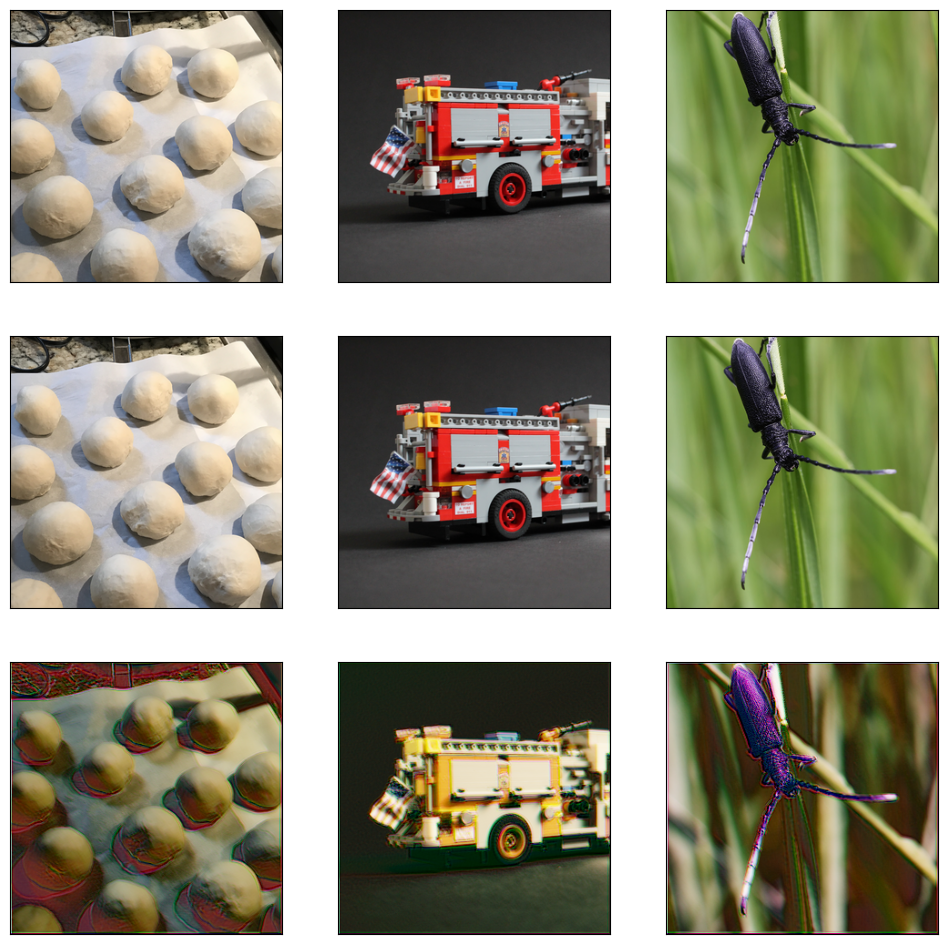

In [98]:
demo_model(model, batch, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


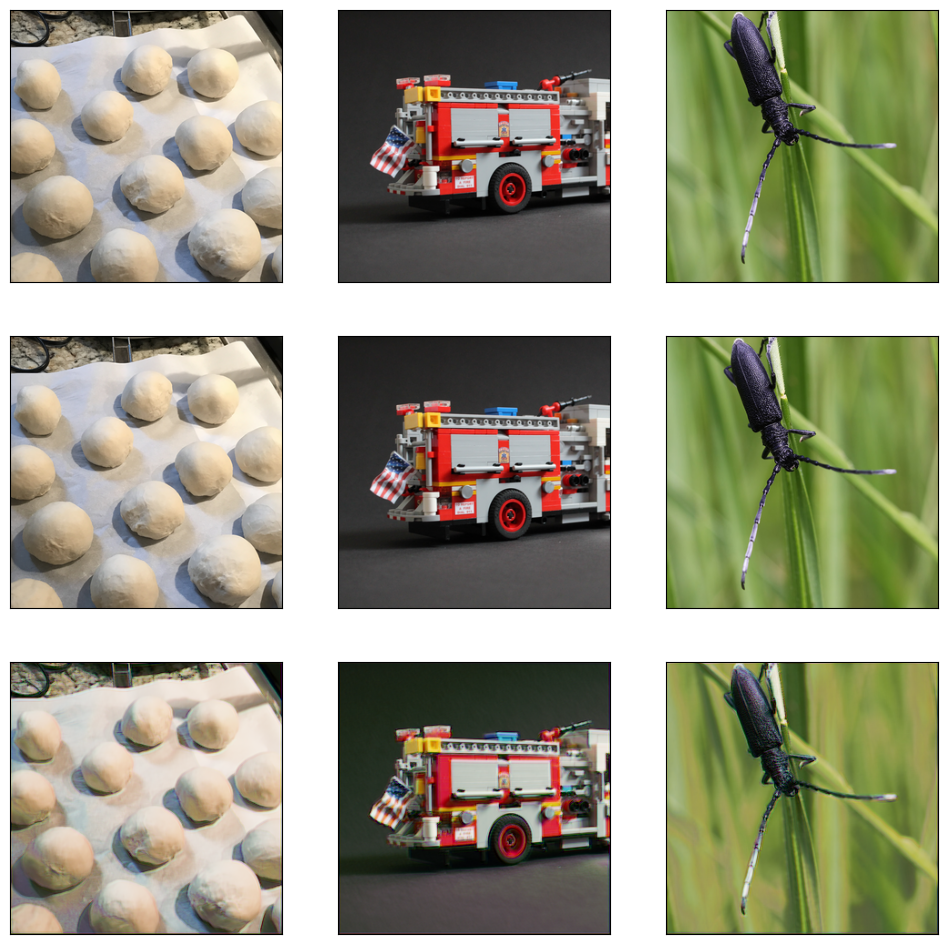

In [86]:
demo_model(model, batch, 3)

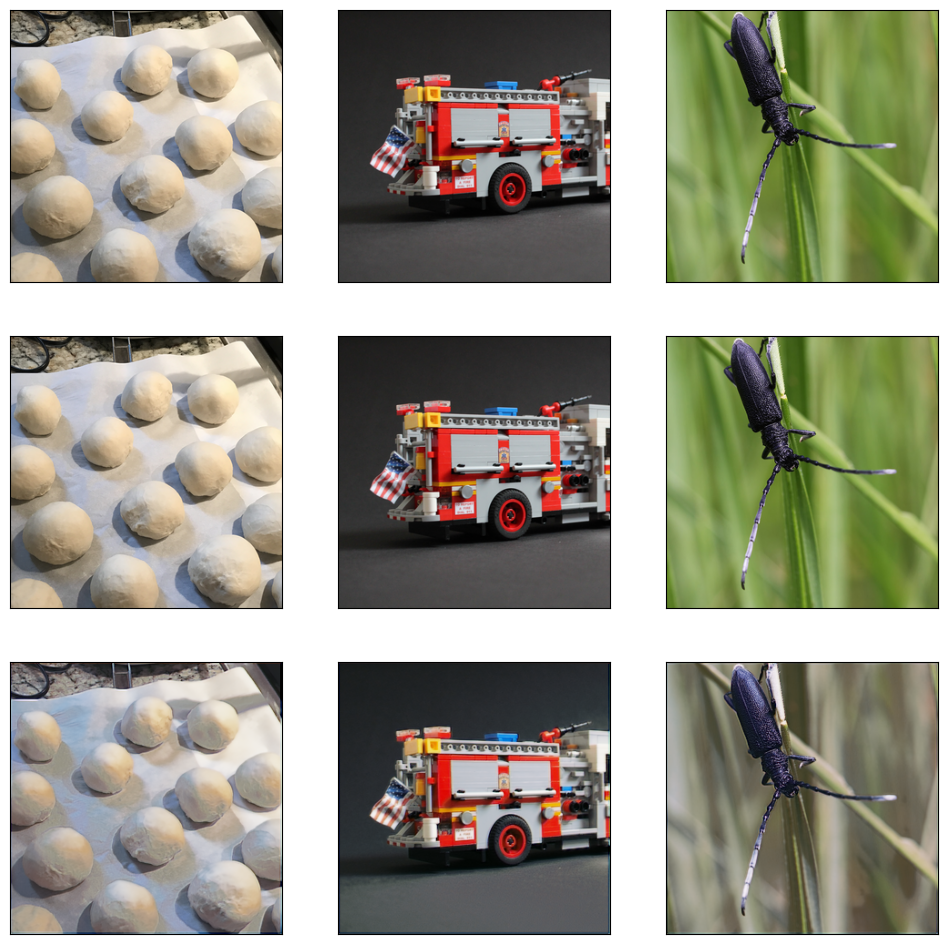

In [87]:
demo_model(model_haled, batch, 3)

In [88]:
torch.save(model.state_dict(), "simple_model_v2.pth")

In [15]:
batch['reference_image'].max()

tensor(1.)

In [42]:
with torch.no_grad():
    pred = model(batch['attacked_image'].to(model.device)).cpu()
batch['attacked_image'].min(), batch['attacked_image'].max(), pred.min(), pred.max()

(tensor(0.), tensor(1.), tensor(249.5580), tensor(255.2973))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


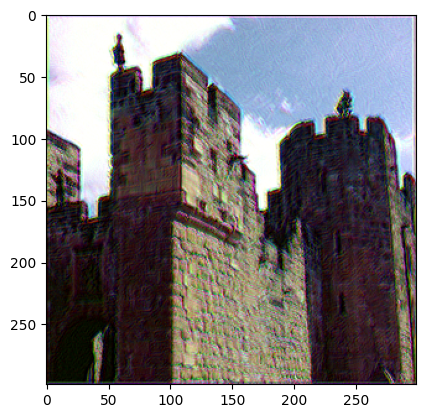

In [25]:
plt.imshow(pred[0].permute(1, 2, 0))